# Homewor 4 - Applied Machine Learning

In this notebook we will present our solution for the 4<sup>th</sup> homework of ADA.

We begin by importing the important librairies.

In [1]:
import pandas as pd                                    
import numpy as np 
import myFunction # the function has been defined by us. See myFunction.py
import seaborn as sns
%matplotlib inline

The first step we do is importing the data and taking a look at it.

In [15]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data.ix[:5,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0


In [16]:
data.ix[:5,13:28]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


#### Data Cleaning

We will start by cleaning the data in several steps. The first computation we do is extracting the rater information. As we saw, the raters disagree often. We decide not to discard values where the raters disagree, but to average the rating given by the two raters. But this does not take into account the Nana values in the rating so it's a complete description of the disagreement.

In [58]:
print('Number of cases where the two raters agree :',
      (data.rater1 == data.rater2).sum()/len(data)*100, ' %')

Number of cases where the two raters agree : 65.5449639795  %


Now we will compute the new column for the average rating.

In [59]:
data_clean0 = data.copy()
data_clean0['meanRating'] = (data.rater1.values + data.rater2.values)/2

As shown in a previous analysis from this [notebook](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb) it was shown that there is a problem regarding data coming from other leagues than the four of interest. For each player there are his games during his entire career, not only the games in the four leagues where the data comes from.

To keep only the main games, we keep referee-dyad players that are present more than 22 times (if a referee officiated 1 matches in a league, he will be present 22 times or more, as there are 22 players in a match).

As we plan to aggregate the data per player, we find that our data will be skewed if we include matches coming from other countries, we will therefore remove them.

In [60]:
refs = data_clean0.refNum.value_counts()

#We pick only the lines where the referee was more than 22 times.
goodRefs = refs[refs>21]

data_clean0 = data_clean0[data_clean0.refNum.isin(goodRefs.index.values)] 

Then, we remove columns that are not relevant (They are not part of the player description or will not be usefull for classification) for the training data and also remove each row where there is no ratings, which means rows where there is no photo ID available, which also means that there is not rater information. These rows are not useful for classification.

We remove these columns:
- photoID
- rater1
- rater2
- playerShort
- birthday
- refNum
- refCountrs 

In [80]:
data_clean1 = data_clean0.dropna(subset=['photoID'])
data_clean2 = data_clean1.drop(['photoID', 'rater1',
                                'rater2', 'playerShort', 'birthday',
                                'refNum', 'refCountry' ],1)

We will also deal with data types. First we take a look at the type of each column.

In [81]:
data_clean2.dtypes

player            object
club              object
leagueCountry     object
height           float64
weight           float64
position          object
games              int64
victories          int64
ties               int64
defeats            int64
goals              int64
yellowCards        int64
yellowReds         int64
redCards           int64
Alpha_3           object
meanIAT          float64
nIAT             float64
seIAT            float64
meanExp          float64
nExp             float64
seExp            float64
meanRating       float64
dtype: object

As we can see, a lot of these columns are of object type. This is a problem because learning algorithms are unable to deal with categorical data. We designed a way to deal with this problem and will show our processing pipeline below.

We begin by changing the null value present in the datatypes below to Unknown

In [82]:
data_clean2.position.fillna("Unknown",inplace=True)
data_clean2.Alpha_3.fillna("Unknown",inplace=True)

We then cast the data types to string to enable using label encoder

In [83]:
data_clean2['position'] = data_clean2['position'].astype('str') 
data_clean2['Alpha_3'] = data_clean2['Alpha_3'].astype('str') 

Then we encode the rest of data sest that are not numerical using the function myfunction that is provided in the main folder.

The encoding basically gives each categorical value in the affected column(column with data type object) a unique identification number. This number is a reference to the object value it represent in the affected column. In this part of the of the homework, we provide provided step by step guide on how to do this. For Example "Attacking MidFielder" in the position column can be encoded as 1.

Below we collect all columns of object datatype from our data set below in CrowdstormingDataJuly1st_object_columns. The aim of this is be able to encode such columns at once. Sklearn as yet does not provide such functionality

In [84]:
data_object = data_clean2.iloc[:, :].select_dtypes(include=['object']).columns

We defined  myFunction.MultiColumnLabelEncoder which  effectively Wraps sklearn LabelEncoder functionality(for encoding categorical variables) for use on multiple columns  of our data set. The multiple columns are those which were extracted above. As can be observed we parsed all such columns into myFunction.MultiColumnLabelEncoder.

In [85]:
#create an instance of MultiColumnLabelEncoder and Pass the columns extracted to it
ColumnObjectEncoder = myFunction.MultiColumnLabelEncoder(columns=data_object)

 The fit method of myFunction.MultiColumnLabelEncoder accesses individual column of our dataset via indexing. This effectively returns the columns of our data set which are of type object.

In [86]:
ColumnObjectEncoder.fit(data_clean2)

MultiColumnLabelEncoder(columns=Index(['player', 'club', 'leagueCountry', 'position', 'Alpha_3'], dtype='object'))

We transform the columns of  object data type to encoded labels. This we do by calling ColumnObjectEncoder.transform.

In [87]:
# Finally transform 
ColumnObjectEncoder.transform(data_clean2)

array([[ 392,   34,    0,    1,   53],
       [ 425,   48,    0,    6,   53],
       [ 440,   54,    0,    4,   53],
       ..., 
       [1536,   12,    2,    7,   42],
       [1541,   91,    0,    8,   42],
       [1553,    1,    2,    9,   42]])

Now we can see that all our columns are numerical value and can be used by the RandomForest classifier

In [88]:
data_clean2.ix[:,:11].head()

,player,club,leagueCountry,height,weight,position,games,victories,ties,defeats,goals
5,392,34,0,182.0,71.0,1,1,0,0,1,0
6,425,48,0,187.0,80.0,6,1,1,0,0,0
7,440,54,0,180.0,68.0,4,1,0,0,1,0
8,454,49,0,193.0,80.0,5,1,0,1,0,0
9,456,2,2,180.0,70.0,9,1,1,0,0,0


In [89]:
data_clean2.ix[:,11:22].head()

,yellowCards,yellowReds,redCards,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,meanRating
5,0,0,0,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
6,0,0,0,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
7,0,0,0,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000
8,0,0,0,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250
9,0,0,0,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000


We then look at the data and we find that there are still a few nan values that are present in the data. But as we see there are not a lot. We decide to let go of them.

In [90]:
data_clean2.isnull().sum()

player             0
club               0
leagueCountry      0
height            23
weight           625
position           0
games              0
victories          0
ties               0
defeats            0
goals              0
yellowCards        0
yellowReds         0
redCards           0
Alpha_3            0
meanIAT          110
nIAT             110
seIAT            110
meanExp          110
nExp             110
seExp            110
meanRating         0
dtype: int64

In [91]:
data_clean2 = data_clean2.dropna()

As we see we have dropped a large set of data, we will check that we did not loose too much data. We see that we only dropped 15% of the data which is quite good.

In [92]:
print('Percentage of data that was kept :',len(data_clean2)/len(data)*100,' %')

Percentage of data that was kept : 77.4693894321637  %


#### Player Aggregation

Now that we have cleaned the data we will aggregate the data per player. We will start by grouping by players and taking a look at one player

In [114]:
players = data_clean2.groupby('player')
players.get_group(34).ix[:,0:12].head()

,player,club,leagueCountry,height,weight,position,games,victories,ties,defeats,goals,yellowCards
2401,34,69,3,177.0,70.0,6,4,0,2,2,0,1
3190,34,69,3,177.0,70.0,6,8,4,2,2,0,0
5475,34,69,3,177.0,70.0,6,7,2,2,3,0,0
5905,34,69,3,177.0,70.0,6,2,1,0,1,0,0
6188,34,69,3,177.0,70.0,6,3,1,2,0,0,2


In [118]:
players.get_group(3).ix[:,12:22].head()

,yellowReds,redCards,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,meanRating
2316,1,0,30,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0.25
3141,0,0,30,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0.25
4013,0,0,76,0.398174,526.0,0.000809,1.212727,550.0,0.004521,0.25
5426,0,0,30,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0.25
5874,0,0,30,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0.25


As we can see, we have to apply different functions that have to be applied for each column for a correct aggregation without loosing any information.

For different columns we will apply different functions:
- club, leagueCountry, height, age, position, Alpha_3, meanRating : Taking the most frequent value in all games is a good representation of the player. (For height, age and meanRating it will be the right value).
- games, victories, ties, defeats, goals, yellowCards, yellowReds, redCards we will sum all the values. 
- For the referee information we will use a custom functions

#### Aggregating referee information

Let's take a custom player represented by the following table, a set of referee - player dyad.

| meanIAT | nIAT | seIAT |
|---------|------|-------|
| $$m_1$$      | $$N_1$$   | $$s_1$$    |
|    $$m_2$$   | $$N_2$$   | $$s_2$$    |
| $$m_3$$      | $$N_3$$   | $$s_3$$    |

Given this information we need to calculate the new values per player that ecompasses the information from all of the dyads for one player.

For the mean we choose the following function:


$$MeanIATPlayer = \frac{m_1*N_1 + m_2*N_2 + m_3*N_3}{N_1+N_2+N_3}$$

The new number of samples is simply:

$$N_{tot} = N_1+N_2+N_33$$

And finally the standard deviation is simply computed with the data above:

$$STD = \sqrt{\frac{1}{N_{tot}}*\sum_{i}^{n}(m_i - meanIATPlayer)^2)}$$


The aggregation is done in the notebook "Aggregation".

In [113]:
data_clean2.to_csv('Cleaned_Data.csv')

In [96]:
len(players.groups)

1551

Now we have to group the data by player and do deal properly with each columns. To do this we create a dict that will contain each function that should be used.

In [71]:
#creation of the dictionary
f = {'height':['mean'],'weight':['mean'],'games':['sum'],'victories':['sum'],'ties':['sum'],
     'defeats':['sum'],'goals':['sum'],'yellowCards':['sum'],
     'yellowReds':['sum'],'redCards':['sum'],
     'meanIAT':['mean'],'seIAT':['std'],'meanExp':['mean'],
     'seExp':['std'],'meanRating':['mean']}

In [72]:
playerGroups = data_clean2.groupby('player')

In [77]:
players = playerGroups.agg(f)
#and keep th column name as index
players.columns = players.columns.droplevel(1)
players.ix[:10,:6]

,height,meanIAT,seIAT,yellowReds,weight,meanExp
player,,,,,,
0,172.00000,0.358428,0.001176,1,67.000000,0.571523
1,184.22807,0.360203,0.001050,0,75.210526,0.534978
2,171.00000,0.365679,0.000223,1,69.000000,0.576993
3,182.00000,0.363666,0.000204,3,78.000000,0.566480
4,190.00000,0.369184,0.001955,0,88.000000,0.583849
5,187.00000,0.370791,0.000123,0,77.000000,0.610543
6,181.00000,0.356769,0.002302,3,77.000000,0.526177
7,186.00000,0.361793,0.000427,0,82.000000,0.551647
8,177.00000,0.369894,0.000000,0,68.000000,0.588297


In [76]:
players.ix[:20,6:]

,goals,redCards,victories,meanRating,games,defeats,seExp,ties,yellowCards
player,,,,,,,,,
0,33,3,229,0.250000,373,85,0.006648,59,58
1,60,0,155,0.155702,323,95,0.007934,73,19
2,39,0,53,0.250000,178,82,0.000978,43,22
3,105,4,125,0.250000,322,115,0.000932,82,68
4,0,1,22,0.000000,44,16,0.015029,6,1
5,52,0,78,0.000000,200,60,0.000675,62,8
6,11,6,292,0.250000,561,130,0.009660,139,197
7,4,3,51,0.125000,171,70,0.002424,50,69
8,1,0,5,0.250000,17,9,0.000000,3,1


In [67]:
players.meanRating.head()

player
0    0.250000
1    0.155702
2    0.250000
3    0.250000
4    0.000000
Name: meanRating, dtype: float64

In [75]:
players.shape

(1572, 15)

We will divide the color of the skin in three categories 0.0, 0.5, 1.0. This is done with the function define below.

In [166]:
#Use the mean of the two raters as the target output (removing the nan, where the photo is not available)

#Removing the mean rating column and storing it into a new dataframe
playersNoNan = players.dropna()
data_features = playersNoNan.drop('meanRating',axis=1)


#We will define the function to transform the ratings.

def transform_rating(series):
    if series <= 0.5:
        return 0.0
    else:
        return 1.0
    
labels = playersNoNan['meanRating'].apply(transform_rating)
labels.shape

#labels = np.asarray(labels, dtype="|S6")

(1548,)

In [167]:
    if series < 0.25:
        return 0.0
    elif series < 0.75:
        return 0.5
    else:
        return 1.0

SyntaxError: 'return' outside function (<ipython-input-167-593d6c494ad9>, line 2)

In [6]:


#remove non numerical columns as we want to predict a continuous value

data_clean3 = data_clean2.select_dtypes(include=['int', 'float'])

data_features = data_clean3.fillna(0)

#Features data
data_features.head(10)

,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,177.0,72.0,1,0,0,1,0,0,0,0,1,1,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,179.0,82.0,1,0,0,1,0,1,0,0,2,2,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
5,182.0,71.0,1,0,0,1,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,187.0,80.0,1,1,0,0,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,180.0,68.0,1,0,0,1,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
8,193.0,80.0,1,0,1,0,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
9,180.0,70.0,1,1,0,0,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
10,177.0,74.0,2,2,0,0,0,1,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
11,181.0,74.0,1,1,0,0,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
12,187.0,80.0,1,1,0,0,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752


In [203]:
#Use the mean of the two raters as the target output (removing the nan, where the photo is not available)

#Labels outputs in the form of series
data_labels = ((data['rater1']+data['rater2'])/2).dropna()
print(type(data_labels))

# Binarization of the output. A rating smaller than 0.4 is equivalent to white
data_labels[data_labels < 0.4] = 0.000
data_labels[data_labels >= 0.4] = 1.000

print(type(data_labels))
print(data_labels.head())
data_labels.shape

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
0    0.0
1    1.0
5    0.0
6    0.0
7    1.0
dtype: float64


(124621,)

In [168]:
from sklearn.ensemble import RandomForestClassifier

#Training accuracy of the random forest classifier on all data

randomforest = RandomForestClassifier()

randomforest.fit(data_features,labels)

data_predict = randomforest.predict(data_features)

# compute classification accuracy for the Random forest classifier model
from sklearn import metrics
print(metrics.accuracy_score(labels, data_predict))


0.978036175711


We see that we obtain a high accurary. But this is only training accuracy obtained by testing our model on the same data used to train it and it doesn't reliably represent the accuracy of the model. For that we need testing accuracy by testing the model on data that were not used for training. We can further increase the reliability by perfoming crossvalidation. This is what is done here after for 10-folds.


In [209]:
from sklearn.cross_validation import cross_val_score

# 10-fold cross-validation

randomforest = RandomForestClassifier(n_estimators=30)
scores = cross_val_score(randomforest, data_features, labels, cv=10, scoring='accuracy')
print(scores)


[ 0.82580645  0.89677419  0.8516129   0.83225806  0.83870968  0.8516129
  0.86451613  0.8516129   0.83870968  0.8627451 ]


With this crossvalidation we obtain a test accuracy for each 10 folds. We can observe that each testing accuracy is well under the training accuracy obtained before. 

We take the average of the 10 testing accuracy to have a reliable value for the testing accuracy of the Random Forest model we used.

In [210]:
scores.mean()

0.85143580012650211

The average testing accuracy is 77% which is not bad but will often make mistake when trying to predict the color of the skin of a player. We will try to improve the scores with features engineerings and by playing with the hyperparameters of the RandomForest model


Here we test the criterion parameter to see if it leads to change in accuracy

In [171]:
# testing the criterion parameter set to 'entropy' (Instead of the default 'gini')

randomforest = RandomForestClassifier(criterion='entropy')
scores = cross_val_score(randomforest, data_features,labels, cv=10, scoring='accuracy')
print(scores)

scores.mean()

[ 0.84516129  0.89677419  0.8516129   0.82580645  0.83870968  0.83870968
  0.87741935  0.83225806  0.8516129   0.86928105]


0.85273455618806671

Using the criterion 'entropy' instead of the default 'gini' (for the Gini impurity) lead to a slightly worse average testing accuracy.

To show the impact of the parameters of the RandomForestClassifier over the overfitting issue we will plot the training and testing accuracy againt different value for tested parameters. We will not use crossvalidation as before as it return the testing accuracy and not the training accuracy. Instead the data set will simply be split into training data and testing data (40% for testing data).


In [172]:
#split data_features and data_labels into training and testing sets
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(data_features, labels, test_size=0.4, random_state=4)


Here we will the see the impact of the parameter 'min_samples_split' which represent the minimum number of samples required to split an internal node. This means that a a bigger number will simplify the model and that the value 2 (the minimum possible) represent the maximum complexity relatively to this parameter.

In [183]:

#Hyperparameter 'min_samples_split'

split_range = list(range(2,16))
print(split_range)
scores_test = []
scores_train = []
for number in split_range:
    randomforest = RandomForestClassifier(min_samples_split=number)
    randomforest.fit(features_train, labels_train)
    labels_pred_test = randomforest.predict(features_test) #testing prediction
    labels_pred_train = randomforest.predict(features_train) #training prediction
    
    scores_test.append(metrics.accuracy_score(labels_test, labels_pred_test)) 
    scores_train.append(metrics.accuracy_score(labels_train, labels_pred_train)) 

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


Now we plot the result for the testing and training accuracy agains the different value of the hyperparameter

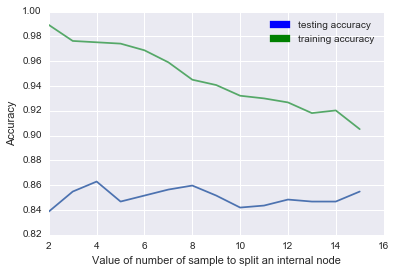

In [184]:
# import Matplotlib (scientific plotting library)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# allow plots to appear within the notebook
%matplotlib inline

# plot the relationship between K and testing accuracy
plt.plot(split_range, scores_test, label='training accuracy')
plt.xlabel('Value of number of sample to split an internal node')
plt.ylabel('Testing Accuracy')

plt.plot(split_range, scores_train, label='testing error')
plt.xlabel('Value of number of sample to split an internal node')
plt.ylabel('Accuracy')

blue = mpatches.Patch(color='blue', label='testing accuracy')
green = mpatches.Patch(color='green', label='training accuracy')
plt.legend(handles=[blue, green])






Indeed we can see that the training accuracy is decreasing with the simplification of the model while the testing accuracy is staying roughly the same (taking the variance into account). In other words the model is overfitting to the training data when we use a small value for this parameter. To be precise, as the testing accuracy doesn't seems to be impacted strongly by the parameter change, the overfitting issue is not really important. True overfitting is when the training accuracy augment while the testing accuracy decrease, which means our model will not generalize well.

Now we will test the n_estimator parameter which represent the number of trees in the forest. This parameter is directly related to the complexity the of the model. Bigger estimator values means more trees which means more complex model.

In [181]:

#Hyperparameter estimator

estimator_range = list(range(5,35))
scores_test = []
scores_train = []
for number in estimator_range:
    randomforest = RandomForestClassifier(n_estimators=number)
    randomforest.fit(features_train, labels_train)
    labels_pred_test = randomforest.predict(features_test) #testing prediction
    labels_pred_train = randomforest.predict(features_train) #training prediction
    
    scores_test.append(metrics.accuracy_score(labels_test, labels_pred_test)) 
    scores_train.append(metrics.accuracy_score(labels_train, labels_pred_train)) 
    
    
    

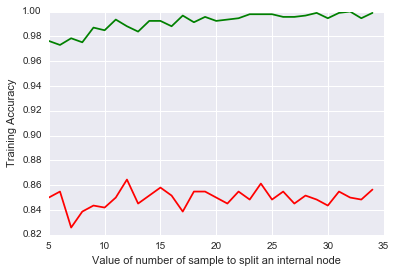

In [182]:
# import Matplotlib (scientific plotting library)
import matplotlib.pyplot as plt

# allow plots to appear within the notebook
%matplotlib inline

# plot the relationship between K and testing accuracy
plt.plot(estimator_range, scores_test,'r')
plt.xlabel('Value of number of sample to split an internal node')
plt.ylabel('Testing Accuracy')

plt.plot(estimator_range, scores_train,'g')
plt.xlabel('Value of number of sample to split an internal node')
plt.ylabel('Training Accuracy')

Here the training accuracy increase continuously while the testing accuracy increase slighlty at the beginning and then reach a plateau (taking the variance into account). Thus the model is overfitting to the training data when we use a too large number of trees (a complex model)

Now we will try to find the best value for the n_estimator parameter using cross validation. We run cross validation for each parameter value and plot the result to see if some value obtain better accuracy. As the number of players is relatively low, even the use of cross validation cannot suppress all the variation.

In [187]:
# search for an optimal value of minimal number of samples required to split an internal node
#Hyperparameter 'min_samples_split'

#We make a 5 folds crossvalidation for each value of the hyperparameter (Not 10 as before for computation time reason)

split_range = list(range(5, 50))
split_scores = []
for number in split_range:
    randomforest = RandomForestClassifier(n_estimators=number)
    scores = cross_val_score(randomforest, data_features, labels, cv=10, scoring='accuracy')
    split_scores.append(scores.mean())
print(split_scores)

[0.81978916297701887, 0.8378621125869703, 0.83847353995361595, 0.83400801180687334, 0.8320303605313093, 0.83788741302972802, 0.84174151380982509, 0.84562091503267978, 0.8443221589711154, 0.84371073160446974, 0.84239510858106681, 0.84626607632300233, 0.8443221589711154, 0.84693653805608271, 0.84690280413240571, 0.85079907231709895, 0.84625764284208316, 0.85400801180687336, 0.84691967109424426, 0.8462745098039216, 0.84758169934640526, 0.8514442336074215, 0.8443221589711154, 0.85469534050179219, 0.84886358844613119, 0.84950874973645374, 0.84951718321737302, 0.84950874973645374, 0.85274298966898576, 0.85144423360742161, 0.84950874973645374, 0.85146110056925983, 0.84888045540796964, 0.85014547754585712, 0.85014547754585712, 0.85082437275985667, 0.84758169934640526, 0.85016234450769568, 0.85016234450769557, 0.85337971747838925, 0.84757326586548598, 0.85272612270714743, 0.84886358844613119, 0.85400801180687336, 0.85145266708834078]


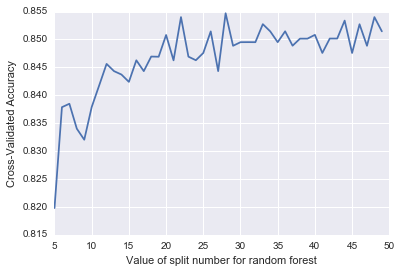

In [188]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(split_range, split_scores)
plt.xlabel('Value of split number for random forest')
plt.ylabel('Cross-Validated Accuracy')

We can observe that the accuracy increase before reaching a 'plateau' around value of 30. So using a value of 30 seems enough complexity for the model, but less than 15 could be bad.

Performing PCA on the features data set doesn't increase the accuracy. It even decrease it a little.

In [214]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)

data_features_pca = pca.fit_transform(data_features)


randomforest = RandomForestClassifier(criterion='entropy', n_estimators=35)
scores = cross_val_score(randomforest, data_features_pca, labels, cv=10, scoring='accuracy')
print(scores)

scores.mean()

[ 0.83225806  0.86451613  0.84516129  0.81935484  0.83870968  0.83225806
  0.81935484  0.83225806  0.83870968  0.84313725]


0.83657179000632509

Now we will investigate feature importance.

In [218]:
randomforest = RandomForestClassifier()

randomforest.fit(data_features,labels)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [219]:
randomforest.feature_importances_

array([ 0.05548303,  0.14521443,  0.10104221,  0.02440488,  0.0533769 ,
        0.10308295,  0.06190125,  0.03157259,  0.07017834,  0.05881271,
        0.0533257 ,  0.13081826,  0.05456656,  0.05622017])

In [220]:

Feature_name = data_features.columns # Get Column Headings of our Dataframe

print((sorted(zip(map(lambda value: round(value, 4), randomforest.feature_importances_), Feature_name), 
             reverse=True))) 

[(0.1452, 'meanIAT'), (0.1308, 'seExp'), (0.1031, 'meanExp'), (0.10100000000000001, 'seIAT'), (0.070199999999999999, 'victories'), (0.061899999999999997, 'goals'), (0.058799999999999998, 'games'), (0.0562, 'yellowCards'), (0.055500000000000001, 'height'), (0.054600000000000003, 'ties'), (0.053400000000000003, 'weight'), (0.0533, 'defeats'), (0.031600000000000003, 'redCards'), (0.024400000000000002, 'yellowReds')]
